# Library loading

In [2]:
%matplotlib inline

import pandas as pd # manipulate dataframes
import matplotlib
import matplotlib.pyplot as plt # plotting
import numpy as np
np.random.seed = 167 # fix random seed for reproducibility
import time, h5py, neuravi, torch

from sklearn.metrics import mean_squared_error

from tqdm import tqdm 

# First we check if CUDA is available
print("CUDA AVAILABLE? ",torch.cuda.is_available())

def get_default_device():
    """Pick GPU if available, else CPU"""
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')
      
device = get_default_device()
print(device)

CUDA AVAILABLE?  True
cuda


In [3]:
path = "./model/best/"
#name_list = pd.read_csv("./model/best/best_list.csv",header=None,names=["name"]).loc[:,"name"]
name_list = pd.read_csv("./model/best/best_list.csv").loc[:,"name"]


In [4]:
len(name_list)

10

In [12]:
# custom data loader, automatically sent to device
ds = neuravi.data_loader("./data/DataSet_0p20val.hdf5",
                         "./data/NKAS_Raman.hdf5",
                         "./data/NKAS_density.hdf5",
                         "./data/NKAS_optical.hdf5",
                         device)

for i in range(len(name_list)):
    name = name_list[i]

    # Extract arch
    nb_layers = int(name[name.find("l")+1:name.find("_n")])
    nb_neurons = int(name[name.find("n")+1:name.rfind("_p")])
    p_drop = float(name[name.find("p")+1:name.rfind(".")])

    neuralmodel = neuravi.model(4,nb_neurons,nb_layers,ds.nb_channels_raman,p_drop=p_drop) 
    neuralmodel.load_state_dict(torch.load(path+name,map_location='cpu'))
    
    # criterion for match
    criterion = torch.nn.MSELoss()
    criterion.to(device) # sending criterion on device
    optimizer = torch.optim.Adam(neuralmodel.parameters(), lr = 0.001) # optimizer
    
    neuralmodel.to(device)
    
    #
    # TRAINING
    #
    neuralmodel, record_train_loss, record_valid_loss = neuravi.training(neuralmodel,ds,
                                                                         criterion,optimizer,path+"dummy.pth",
                                                                         train_patience=1,min_delta=0.1,
                                                                         verbose=True)

Full training.

Epoch 0 => train loss: 0.263424813747406; valid loss: 2.0168285369873047
Running time in seconds: 0.20882081985473633
Full training.

Epoch 0 => train loss: 0.3521386384963989; valid loss: 1.9422094821929932
Running time in seconds: 0.10745739936828613
Full training.

Epoch 0 => train loss: 0.30120185017585754; valid loss: 2.0404200553894043
Running time in seconds: 0.1287524700164795
Full training.

Epoch 0 => train loss: 0.7615068554878235; valid loss: 2.3535847663879395
Running time in seconds: 0.13331246376037598
Full training.

Epoch 0 => train loss: 0.9871142506599426; valid loss: 2.636173725128174
Running time in seconds: 0.11290788650512695
Full training.

Epoch 0 => train loss: 0.979489266872406; valid loss: 2.4788930416107178
Running time in seconds: 0.12797164916992188
Full training.

Epoch 0 => train loss: 1.0132893323898315; valid loss: 2.475832223892212
Running time in seconds: 0.1284961700439453
Full training.

Epoch 0 => train loss: 0.7708467245101929; v

In [ ]:
self.models[i] = neuravi.model(4,nb_neurons,nb_layers,ds.nb_channels_raman,p_drop=p_drop) 
    self.models[i]
    self.models[i].eval()

# Training 1 model 

Architecture: 4 layers, 300 neurons per layer, dropout 0.5

With such high dropout, we may want to increase the patience quite significantly. This notebook was created to tune this.

In [4]:
#
# Parameters
#
nb_neurons = 300
nb_layers = 4
p_drop = 0.4

# custom data loader, automatically sent to device
ds = neuravi.data_loader("./data/DataSet_0p20val.hdf5",
                         "./data/NKAS_Raman.hdf5",
                         "./data/NKAS_density.hdf5",
                         "./data/NKAS_optical.hdf5",
                         device)


name = "./model/best/l"+str(nb_layers)+"_n"+str(nb_neurons)+"_p"+str(p_drop)+"_test"+".pth"

# declaring model
neuralmodel = neuravi.model(4,nb_neurons,nb_layers,ds.nb_channels_raman,p_drop=p_drop) 

# criterion for match
criterion = torch.nn.MSELoss()
criterion.to(device) # sending criterion on device
optimizer = torch.optim.Adam(neuralmodel.parameters(), lr = 0.001) # optimizer

# we initialize the output bias and send the neural net on device
neuralmodel.output_bias_init()
neuralmodel.to(device)

#
# PRETRAINING
#
neuralmodel, record_pretrain_loss, record_prevalid_loss = neuravi.training(neuralmodel,ds,criterion,optimizer,name, mode="pretrain",verbose=False)

#
# TRAINING
#
neuralmodel, record_train_loss, record_valid_loss = neuravi.training(neuralmodel,ds,
                                                                     criterion,optimizer,name,
                                                                     train_patience=500,min_delta=0.1,
                                                                     verbose=True)


Full training.

Epoch 0 => train loss: 10.99420166015625; valid loss: 12.915542602539062
Epoch 200 => train loss: 4.428297519683838; valid loss: 5.820215702056885
Epoch 400 => train loss: 3.6449332237243652; valid loss: 5.619622707366943
Epoch 600 => train loss: 3.2816498279571533; valid loss: 5.43583869934082
Epoch 800 => train loss: 2.9917635917663574; valid loss: 5.008788585662842
Epoch 1000 => train loss: 2.71262264251709; valid loss: 4.772281169891357
Epoch 1200 => train loss: 2.4331979751586914; valid loss: 4.620238304138184
Epoch 1400 => train loss: 2.1989634037017822; valid loss: 4.7866291999816895
Running time in seconds: 70.68150186538696


# Observing how losses decline

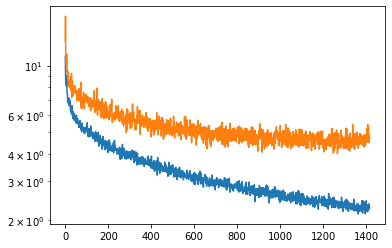

In [5]:
plt.plot(record_train_loss,label="valid")
plt.plot(record_valid_loss,label="train")
plt.yscale("log")

# Training 50 models with selected architecture

From the experiments, high dropout with 4 layers and 300 neurons may be a good architecture.
We train 50 networks with this architecture.

In [6]:
#
# Parameters
#
nb_exp = 10
nb_neurons = 300
nb_layers = 4
p_drop = 0.4

# custom data loader, automatically sent to device
ds = neuravi.data_loader("./data/DataSet_0p20val.hdf5",
                         "./data/NKAS_Raman.hdf5",
                         "./data/NKAS_density.hdf5",
                         "./data/NKAS_optical.hdf5",
                         device)

for i in tqdm(range(nb_exp)):
    # name for saving
    name = "./model/best/l"+str(nb_layers)+"_n"+str(nb_neurons)+"_p"+str(p_drop)+"_no"+str(i+1)+".pth"
    
    # declaring model
    neuralmodel = neuravi.model(4,nb_neurons,nb_layers,ds.nb_channels_raman,p_drop=p_drop) 

    # criterion for match
    criterion = torch.nn.MSELoss()
    criterion.to(device) # sending criterion on device
    optimizer = torch.optim.Adam(neuralmodel.parameters(), lr = 0.0001) # optimizer

    # we initialize the output bias and send the neural net on device
    neuralmodel.output_bias_init()
    neuralmodel.to(device)
    
    #
    # PRETRAINING
    #
    neuralmodel, record_pretrain_loss, record_prevalid_loss = neuravi.training(neuralmodel,ds,criterion,optimizer,name, mode="pretrain",verbose=False)
                
    #
    # TRAINING
    #
    neuralmodel, record_train_loss, record_valid_loss = neuravi.training(neuralmodel,ds,criterion,optimizer,name,train_patience=500,min_delta=0.1,verbose=True)


  0%|          | 0/10 [00:00<?, ?it/s]

Full training.

Epoch 0 => train loss: 280.8157043457031; valid loss: 20.71263313293457
Epoch 200 => train loss: 11.828886985778809; valid loss: 16.18202018737793
Epoch 400 => train loss: 10.948797225952148; valid loss: 13.833198547363281
Epoch 600 => train loss: 9.644498825073242; valid loss: 12.510293006896973
Epoch 800 => train loss: 9.367962837219238; valid loss: 11.726655960083008
Epoch 1000 => train loss: 7.965926170349121; valid loss: 11.819397926330566
Epoch 1200 => train loss: 7.9930739402771; valid loss: 11.77450942993164
Epoch 1400 => train loss: 7.59660530090332; valid loss: 11.422704696655273
Epoch 1600 => train loss: 6.765867233276367; valid loss: 10.372930526733398
Epoch 1800 => train loss: 6.624847888946533; valid loss: 9.647234916687012
Epoch 2000 => train loss: 6.007593154907227; valid loss: 9.219747543334961
Epoch 2200 => train loss: 5.934643268585205; valid loss: 8.595474243164062
Epoch 2400 => train loss: 5.581204891204834; valid loss: 8.121053695678711
Epoch 2600 

 10%|█         | 1/10 [05:45<51:53, 346.00s/it]

Running time in seconds: 321.5641369819641
Full training.

Epoch 0 => train loss: 20.808866500854492; valid loss: 20.938955307006836
Epoch 200 => train loss: 11.612351417541504; valid loss: 14.774163246154785
Epoch 400 => train loss: 10.016566276550293; valid loss: 12.722190856933594
Epoch 600 => train loss: 8.179576873779297; valid loss: 10.737878799438477
Epoch 800 => train loss: 7.079944133758545; valid loss: 10.28429126739502
Epoch 1000 => train loss: 6.915361404418945; valid loss: 8.734396934509277
Epoch 1200 => train loss: 6.195070266723633; valid loss: 9.066959381103516
Epoch 1400 => train loss: 5.653791904449463; valid loss: 9.308621406555176
Epoch 1600 => train loss: 5.621465682983398; valid loss: 7.543982982635498
Epoch 1800 => train loss: 4.9543914794921875; valid loss: 7.113917350769043
Epoch 2000 => train loss: 4.836630821228027; valid loss: 7.33010196685791
Epoch 2200 => train loss: 4.957650184631348; valid loss: 6.433929920196533
Epoch 2400 => train loss: 4.3075690269470

 20%|██        | 2/10 [09:10<40:27, 303.48s/it]

Running time in seconds: 189.60421180725098
Full training.

Epoch 0 => train loss: 28.63829803466797; valid loss: 22.04741668701172
Epoch 200 => train loss: 11.739607810974121; valid loss: 15.460212707519531
Epoch 400 => train loss: 9.701844215393066; valid loss: 12.892765998840332
Epoch 600 => train loss: 8.804312705993652; valid loss: 10.239629745483398
Epoch 800 => train loss: 7.938627243041992; valid loss: 10.427026748657227
Epoch 1000 => train loss: 6.8293328285217285; valid loss: 9.506004333496094
Epoch 1200 => train loss: 6.736631393432617; valid loss: 8.415918350219727
Epoch 1400 => train loss: 6.202407360076904; valid loss: 8.565092086791992
Epoch 1600 => train loss: 5.6694769859313965; valid loss: 7.399832725524902
Epoch 1800 => train loss: 5.137433052062988; valid loss: 7.879782676696777
Epoch 2000 => train loss: 5.3037214279174805; valid loss: 7.20863151550293
Epoch 2200 => train loss: 4.85630989074707; valid loss: 6.9136481285095215
Epoch 2400 => train loss: 4.670041084289

 30%|███       | 3/10 [11:46<30:15, 259.35s/it]

Running time in seconds: 135.094167470932
Full training.

Epoch 0 => train loss: 21.08022689819336; valid loss: 24.300355911254883
Epoch 200 => train loss: 12.689918518066406; valid loss: 14.830099105834961
Epoch 400 => train loss: 11.682637214660645; valid loss: 14.422789573669434
Epoch 600 => train loss: 9.806729316711426; valid loss: 12.230467796325684
Epoch 800 => train loss: 9.686601638793945; valid loss: 12.138177871704102
Epoch 1000 => train loss: 8.715412139892578; valid loss: 10.983859062194824
Epoch 1200 => train loss: 8.365198135375977; valid loss: 10.842108726501465
Epoch 1400 => train loss: 7.800526142120361; valid loss: 9.983955383300781
Epoch 1600 => train loss: 9.470587730407715; valid loss: 11.016921043395996


 40%|████      | 4/10 [14:07<22:22, 223.79s/it]

Running time in seconds: 116.84181451797485
Full training.

Epoch 0 => train loss: 20.052515029907227; valid loss: 20.157283782958984
Epoch 200 => train loss: 10.872705459594727; valid loss: 14.990193367004395
Epoch 400 => train loss: 8.989479064941406; valid loss: 11.561939239501953
Epoch 600 => train loss: 7.640673637390137; valid loss: 11.109347343444824
Epoch 800 => train loss: 7.157914638519287; valid loss: 10.875531196594238
Epoch 1000 => train loss: 6.240203380584717; valid loss: 9.668327331542969
Epoch 1200 => train loss: 6.36760139465332; valid loss: 9.158945083618164
Epoch 1400 => train loss: 5.9699578285217285; valid loss: 8.979129791259766
Epoch 1600 => train loss: 5.586763381958008; valid loss: 8.547657012939453
Epoch 1800 => train loss: 5.349096298217773; valid loss: 8.451473236083984
Epoch 2000 => train loss: 5.331518173217773; valid loss: 7.732250690460205
Epoch 2200 => train loss: 5.005018711090088; valid loss: 7.4186577796936035
Epoch 2400 => train loss: 4.69732332229

 50%|█████     | 5/10 [17:25<18:00, 216.10s/it]

Running time in seconds: 174.0045988559723
Full training.

Epoch 0 => train loss: 31.199018478393555; valid loss: 22.50446128845215
Epoch 200 => train loss: 14647.4033203125; valid loss: 8847.86328125
Epoch 400 => train loss: 33463.1328125; valid loss: 5162.978515625


 60%|██████    | 6/10 [18:16<11:06, 166.61s/it]

Running time in seconds: 31.35784101486206
Full training.

Epoch 0 => train loss: 21.992631912231445; valid loss: 20.93930435180664
Epoch 200 => train loss: 14.29671859741211; valid loss: 17.692808151245117
Epoch 400 => train loss: 13.535090446472168; valid loss: 15.601816177368164
Epoch 600 => train loss: 12.825249671936035; valid loss: 14.092595100402832
Epoch 800 => train loss: 12.919707298278809; valid loss: 13.85775375366211
Epoch 1000 => train loss: 11.009458541870117; valid loss: 13.984245300292969
Epoch 1200 => train loss: 10.843550682067871; valid loss: 14.000170707702637
Epoch 1400 => train loss: 9.718111991882324; valid loss: 12.70923900604248
Epoch 1600 => train loss: 9.799649238586426; valid loss: 11.839919090270996
Epoch 1800 => train loss: 8.986692428588867; valid loss: 11.005765914916992
Epoch 2000 => train loss: 9.265525817871094; valid loss: 12.978730201721191
Epoch 2200 => train loss: 8.66655445098877; valid loss: 12.55771255493164
Epoch 2400 => train loss: 8.5422449

 70%|███████   | 7/10 [21:51<09:02, 180.98s/it]

Running time in seconds: 192.21892666816711
Full training.

Epoch 0 => train loss: 96.65737915039062; valid loss: 68.08807373046875
Epoch 200 => train loss: 29.17683982849121; valid loss: 36.29627990722656
Epoch 400 => train loss: 21.80646514892578; valid loss: 25.074438095092773
Epoch 600 => train loss: 16.78768539428711; valid loss: 20.208951950073242
Epoch 800 => train loss: 13.704585075378418; valid loss: 16.346912384033203
Epoch 1000 => train loss: 12.07626724243164; valid loss: 13.434793472290039
Epoch 1200 => train loss: 9.954131126403809; valid loss: 11.958457946777344
Epoch 1400 => train loss: 9.524372100830078; valid loss: 12.877337455749512
Epoch 1600 => train loss: 8.5761137008667; valid loss: 10.503467559814453
Epoch 1800 => train loss: 8.458292007446289; valid loss: 10.988225936889648
Epoch 2000 => train loss: 7.380174160003662; valid loss: 10.521034240722656
Epoch 2200 => train loss: 7.332451820373535; valid loss: 10.215391159057617
Epoch 2400 => train loss: 6.8584971427

KeyboardInterrupt: 

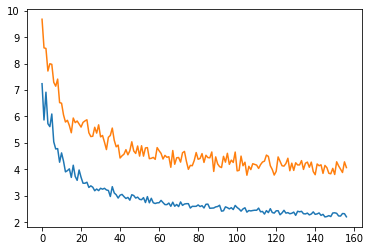